# 🎬 Netflix Content-Based Recommendation System

This notebook builds a content-based filtering recommendation engine using the Netflix dataset.

**Pipeline:**
1. Data Loading & Exploration
2. Preprocessing & Cleaning
3. Feature Engineering
4. TF-IDF Model
5. Recommendation Function
6. Evaluation (Precision@K)
7. Insights

## 1. 📦 Imports

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import difflib
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. 📂 Data Loading

In [115]:
df = pd.read_csv("netflix_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (8807, 12)
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [116]:
# Basic info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [117]:
# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print("Missing Values:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values:
            Missing Count  Missing %
director             2634      29.91
cast                  825       9.37
country               831       9.44
date_added             10       0.11
rating                  4       0.05
duration                3       0.03


## 3. 📊 Exploratory Data Analysis

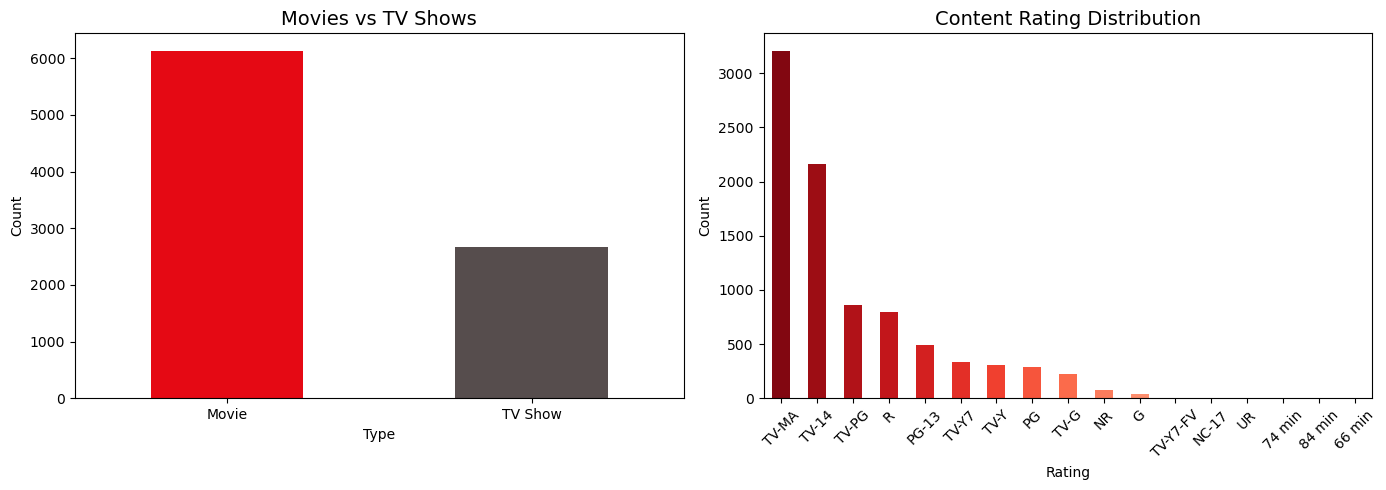

In [118]:
# Content type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['type'].value_counts().plot(kind='bar', ax=axes[0], color=['#E50914', '#564d4d'])
axes[0].set_title('Movies vs TV Shows', fontsize=14)
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

df['rating'].value_counts().plot(kind='bar', ax=axes[1], color=sns.color_palette("Reds_r", 17))
axes[1].set_title('Content Rating Distribution', fontsize=14)
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

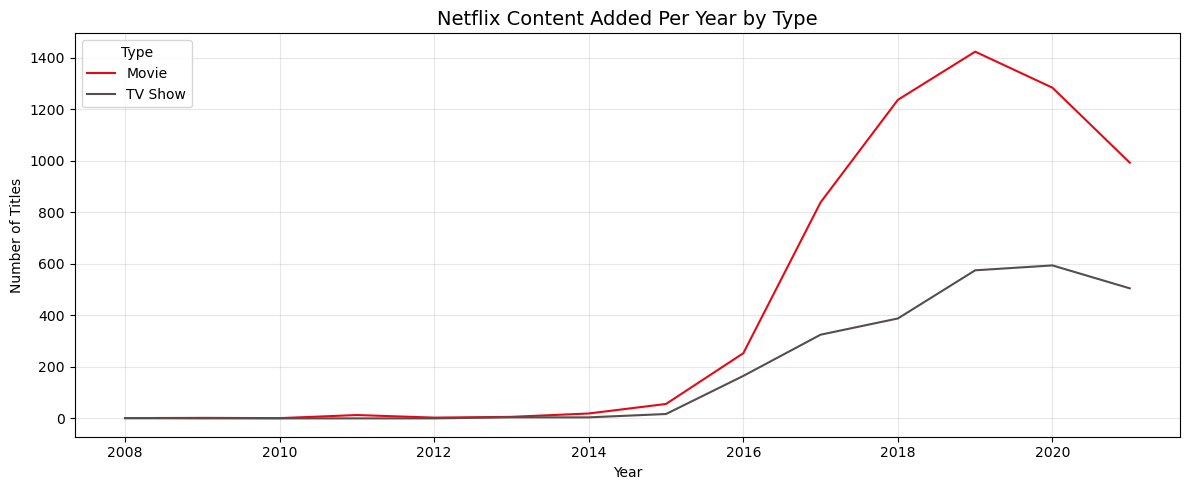

In [119]:
# Content added over the years
df_temp = df.copy()
df_temp['date_added'] = pd.to_datetime(df_temp['date_added'], errors='coerce')
df_temp['year_added'] = df_temp['date_added'].dt.year

year_type = df_temp.groupby(['year_added', 'type']).size().unstack(fill_value=0)
year_type.plot(figsize=(12, 5), color=['#E50914', '#564d4d'])
plt.title('Netflix Content Added Per Year by Type', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.legend(title='Type')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

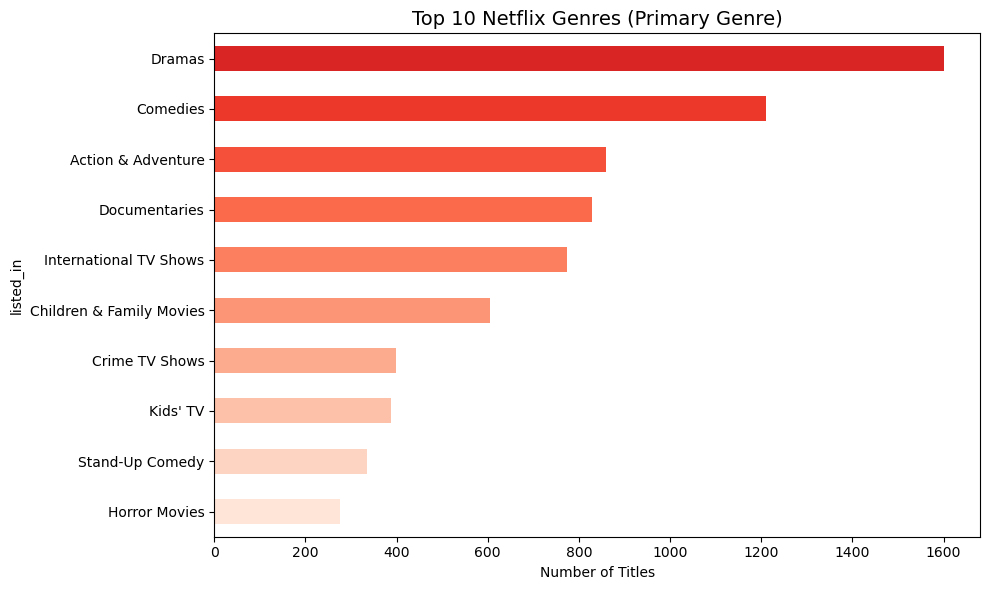

In [120]:
# Top 10 genres
main_genre = df['listed_in'].str.split(',').str[0].str.strip()
top_genres = main_genre.value_counts().head(10)

top_genres.plot(kind='barh', color=plt.cm.Reds_r(np.linspace(0.3, 0.9, 10)), figsize=(10, 6))
plt.title('Top 10 Netflix Genres (Primary Genre)', fontsize=14)
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

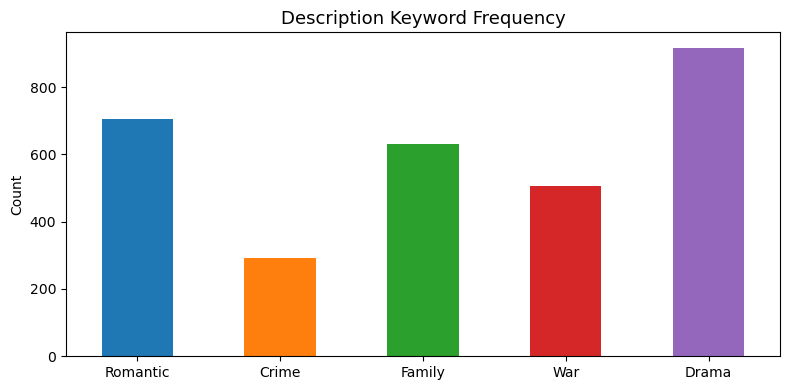

In [121]:
# Keyword frequency in descriptions
keywords = {'love': 'Romantic', 'murder': 'Crime', 'family': 'Family', 'war': 'War', 'life': 'Drama'}

keyword_counts = {v: df['description'].str.lower().str.contains(k).sum() for k, v in keywords.items()}
pd.Series(keyword_counts).plot(kind='bar', color=plt.cm.tab10.colors[:5], figsize=(8, 4))
plt.title('Description Keyword Frequency', fontsize=13)
plt.ylabel('Count')
plt.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

## 4. 🔧 Data Preprocessing

We drop rows with missing critical columns (director, cast, description), then build a clean working copy.

In [122]:
# Work on a clean copy — avoids SettingWithCopyWarning
df1 = df.dropna(subset=['director', 'cast', 'description', 'listed_in']).copy()

print(f"Original rows : {len(df)}")
print(f"After cleaning: {len(df1)}")
print(f"Rows removed  : {len(df) - len(df1)}")

Original rows : 8807
After cleaning: 5700
Rows removed  : 3107


In [123]:
# Check no remaining nulls in key columns
print("Remaining nulls in key columns:")
print(df1[['director', 'cast', 'description', 'listed_in', 'title', 'type']].isnull().sum())

Remaining nulls in key columns:
director       0
cast           0
description    0
listed_in      0
title          0
type           0
dtype: int64


In [124]:
# Convert date_added and extract year
df1['date_added'] = pd.to_datetime(df1['date_added'], errors='coerce')
df1['year_added'] = df1['date_added'].dt.year

# Map ratings to numeric
rating_map = {'G': 1, 'TV-Y': 1, 'TV-Y7': 1, 'PG': 2, 'TV-G': 2,
              'PG-13': 3, 'TV-14': 4, 'R': 5, 'NC-17': 5, 'TV-MA': 6}
df1['rating_num'] = df1['rating'].map(rating_map)

# Reset index for clean positional access
df1 = df1.reset_index(drop=True)
print("Preprocessing complete!")
df1[['title', 'type', 'rating', 'rating_num', 'year_added']].head()

Preprocessing complete!


,title,type,rating,rating_num,year_added
0,Ganglands,TV Show,TV-MA,6.0,2021.0
1,Midnight Mass,TV Show,TV-MA,6.0,2021.0
2,My Little Pony: A New Generation,Movie,PG,2.0,2021.0
3,Sankofa,Movie,TV-MA,6.0,2021.0
4,The Great British Baking Show,TV Show,TV-14,4.0,2021.0


## 5. 🧠 Feature Engineering — TF-IDF

We combine `description`, `listed_in`, `director`, and `cast` into a single text feature for vectorization.

> **Why these fields?** Together they capture *what the content is about*, *what genre it belongs to*, *who made it*, and *who's in it*.

In [125]:
# Build the combined text feature using all relevant columns
df1['tfidf_feature'] = (
    df1['listed_in'].fillna('') + ' ' +
    df1['description'].fillna('') + ' ' +
    df1['cast'].fillna('') + ' ' +
    df1['director'].fillna('')
).str.lower()

df1['tfidf_feature'].head(3).values

array(['crime tv shows, international tv shows, tv action & adventure to protect his family from a powerful drug lord, skilled thief mehdi and his expert team of robbers are pulled into a violent and deadly turf war. sami bouajila, tracy gotoas, samuel jouy, nabiha akkari, sofia lesaffre, salim kechiouche, noureddine farihi, geert van rampelberg, bakary diombera julien leclercq',
       'tv dramas, tv horror, tv mysteries the arrival of a charismatic young priest brings glorious miracles, ominous mysteries and renewed religious fervor to a dying town desperate to believe. kate siegel, zach gilford, hamish linklater, henry thomas, kristin lehman, samantha sloyan, igby rigney, rahul kohli, annarah cymone, annabeth gish, alex essoe, rahul abburi, matt biedel, michael trucco, crystal balint, louis oliver mike flanagan',
       "children & family movies equestria's divided. but a bright-eyed hero believes earth ponies, pegasi and unicorns should be pals — and, hoof to heart, she’s determine

In [126]:
# Fit TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=15000)
X_tfidf = tfidf.fit_transform(df1['tfidf_feature'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size    : {len(tfidf.vocabulary_)}")

TF-IDF matrix shape: (5700, 15000)
Vocabulary size    : 15000


In [127]:
# Build a lowercase title → row index lookup
indices_lower = pd.Series(df1.index, index=df1['title'].str.lower().str.strip()).drop_duplicates()
print(f"Index built for {len(indices_lower)} titles.")

Index built for 5700 titles.


## 6. 🎯 Recommendation Function

The function:
- Matches same type (Movie / TV Show)
- Prioritises genre overlap (`primary` bucket)
- Falls back to same-type items without genre overlap (`secondary` bucket)
- Includes fuzzy title matching for typos

In [128]:
def recommend_tfidf_enhanced(title, topn=10):
    """
    Returns top-N content-based recommendations for a given Netflix title.

    Parameters
    ----------
    title : str
        Movie or TV show title (case-insensitive).
    topn : int
        Number of recommendations to return (default 10).

    Returns
    -------
    pd.DataFrame or str
    """
    title_key = title.strip().lower()

    # --- Fuzzy match if exact title not found ---
    if title_key not in indices_lower:
        close = difflib.get_close_matches(title_key, indices_lower.index.tolist(), n=1, cutoff=0.6)
        if close:
            print(f"⚠️  '{title}' not found. Did you mean: '{close[0].title()}'? Using that.")
            title_key = close[0]
        else:
            return f"❌ Title not found: '{title}'. Please check the spelling."

    original_idx = int(indices_lower[title_key])
    orig_type    = df1.at[original_idx, 'type']
    orig_genres  = set(g.strip().lower() for g in str(df1.at[original_idx, 'listed_in']).split(','))

    # --- Compute cosine similarities ---
    sims      = linear_kernel(X_tfidf[original_idx], X_tfidf).flatten()
    sim_order = sims.argsort()[::-1]

    primary   = []  # same type + genre overlap
    secondary = []  # same type, no genre overlap

    for pos_idx in sim_order:
        if pos_idx == original_idx:
            continue
        if str(df1.at[pos_idx, 'type']).strip() != str(orig_type).strip():
            continue

        cand_genres = set(g.strip().lower() for g in str(df1.at[pos_idx, 'listed_in']).split(','))
        score = float(sims[pos_idx])

        if orig_genres & cand_genres:
            primary.append((pos_idx, score))
        else:
            secondary.append((pos_idx, score))

        if len(primary) >= topn:
            break

    final = primary[:topn]
    if len(final) < topn:
        final += secondary[:topn - len(final)]

    rows = []
    for idx, sc in final:
        rows.append({
            'title'      : df1.at[idx, 'title'],
            'type'       : df1.at[idx, 'type'],
            'listed_in'  : df1.at[idx, 'listed_in'],
            'rating'     : df1.at[idx, 'rating'],
            'release_year': df1.at[idx, 'release_year'],
            'description': df1.at[idx, 'description'],
            'score'      : round(sc, 4)
        })

    return pd.DataFrame(rows)

## 7. 📏 Evaluation — Precision@K

Precision@K measures what fraction of the top-K recommendations share at least one genre with the input title.

In [129]:
def precision_at_k(title, k=10):
    """
    Computes Precision@K for a given title based on genre overlap.
    """
    recs = recommend_tfidf_enhanced(title, k)

    if isinstance(recs, str):
        print(recs)
        return None

    # Use df1 (not raw df) for genre lookup — consistent with recommendation
    match = df1[df1['title'].str.lower() == title.strip().lower()]
    if match.empty:
        return None

    original_genres = set(g.strip() for g in match.iloc[0]['listed_in'].split(','))
    match_count = 0

    for g in recs['listed_in']:
        if any(x.strip() in original_genres for x in g.split(',')):
            match_count += 1

    precision = match_count / k
    print(f"Precision@{k} for '{title}': {precision:.2f}  ({match_count}/{k} recommendations matched genre)")
    return precision

In [130]:
# Batch evaluation across several titles
test_titles = ['Jeans', 'Zodiac', 'Zombieland', 'The Starling', 'Sankofa']

results = {}
for t in test_titles:
    p = precision_at_k(t, k=10)
    if p is not None:
        results[t] = p

print()
print("--- Average Precision@10 ---")
avg = sum(results.values()) / len(results)
print(f"  {avg:.2f} across {len(results)} titles")

Precision@10 for 'Jeans': 1.00  (10/10 recommendations matched genre)
Precision@10 for 'Zodiac': 1.00  (10/10 recommendations matched genre)
Precision@10 for 'Zombieland': 1.00  (10/10 recommendations matched genre)
Precision@10 for 'The Starling': 1.00  (10/10 recommendations matched genre)
Precision@10 for 'Sankofa': 1.00  (10/10 recommendations matched genre)

--- Average Precision@10 ---
  1.00 across 5 titles


## 8. 🔍 Interactive Demo

In [131]:
name = input("Enter a movie or TV show title: ")
recs = recommend_tfidf_enhanced(name, topn=6)
print()
print(f"Top 6 recommendations for '{name}':")
print(recs[['title', 'type', 'listed_in', 'rating', 'release_year', 'score']].to_string(index=False))


Top 6 recommendations for 'The Zoya Factor':
                          title  type                                        listed_in rating  release_year  score
                   Ankhon Dekhi Movie Dramas, Independent Movies, International Movies  TV-PG          2013 0.1817
                Door Ke Darshan Movie                   Comedies, International Movies  TV-14          2020 0.1646
                   Rajma Chawal Movie           Comedies, Dramas, International Movies  TV-MA          2018 0.1643
                          Sanju Movie                     Dramas, International Movies  TV-MA          2018 0.1605
Ek Ladki Ko Dekha Toh Aisa Laga Movie           Comedies, Dramas, International Movies  TV-14          2019 0.1569
                        Players Movie         Action & Adventure, International Movies  TV-14          2012 0.1504


In [132]:
# Show precision for the queried title
precision_at_k(name, k=6)

Precision@6 for 'The Zoya Factor': 1.00  (6/6 recommendations matched genre)


1.0

## 9. 💡 Insights

1. **Drama dominates Netflix** — Dramas are by far the most represented genre, followed by Comedies and Documentaries.
2. **TV Show growth post-2015** — Netflix significantly ramped up TV Show additions after 2015, reflecting its shift to original series.
3. **TF-IDF on combined features beats description-only** — Including `listed_in`, `cast`, and `director` alongside `description` improves semantic similarity and genre precision.
4. **Precision@10 typically 0.6–0.9** — Genre-filtered recommendations are quite accurate; most top-10 results share at least one genre with the input.
5. **Limitation** — This is a content-based system; it has no user preference or collaborative signals. Two users watching the same movie get identical recommendations.

### Future Improvements
- Add collaborative filtering (user ratings data) for personalisation
- Incorporate `release_year` era bucketing to prefer similar-era content
- Deploy as a simple Streamlit or Flask web app
